### ST Assignement 3: 

##### Hocine Samy
##### Bazaz Jazayeri Samuel 

### Setup

**Imports**

In [1]:
import librosa
import datetime as dt
from math import log

from IPython.display import Audio 
from IPython.core.display import display

import numpy as np
import ruptures as rpt

rng = np.random.default_rng()

C:\Users\samud\AppData\Local\Temp\ipykernel_23220\2474862364.py:6: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


In [177]:
!pip install librosa

   ---------------------------------------- 0.0/253.7 kB ? eta -:--:--
   ---------------------- ----------------- 143.4/253.7 kB 4.3 MB/s eta 0:00:01
   ---------------------------------------- 253.7/253.7 kB 5.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/222.7 kB ? eta -:--:--
   --------------------------------------- 222.7/222.7 kB 14.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/62.7 kB ? eta -:--:--
   ---------------------------------------- 62.7/62.7 kB ? eta 0:00:00
   ---------------------------------------- 0.0/184.8 kB ? eta -:--:--
   ---------------------------------------- 184.8/184.8 kB ? eta 0:00:00


In [2]:
############
# Packages #
############
import os
import sys
import scipy
import pywt

import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns
import matplotlib.pyplot as plt


from pathlib import Path
from itertools import product
from sklearn.metrics import mean_squared_error
from prettytable import PrettyTable
from typing import Dict, Union, List, Tuple, Any, Callable, Optional
pio.renderers.default = "plotly_mimetype+notebook"

In [3]:
###################
#   ploting st    #
###################
#Color
def my_pal(n):
    return sns.color_palette("Spectral", n).as_hex()

#Simple
def plot_signal(vec, title = "signal"):
    fig = px.line(vec, template = "plotly_dark", title = title)
    fig.show()
    
def plot_all_st(X, clustering=None, title="<b>Signals</b>"):
    """
    Plot multiple signals in a single interactive Plotly figure.

    Args:
        X (list of arrays): A list of signal arrays to be plotted.
        clustering (list or None, optional): A list of cluster assignments for each signal. 
            If provided, signals will be color-coded by cluster. Default is None.
        title (str, optional): The title of the plot. Default is "<b>Signals</b>".

    Returns:
        None: Displays an interactive Plotly figure with the plotted signals.
    """
    
    fig = go.Figure(
        layout=go.Layout(
            height=600, 
            width=800, 
            template = "plotly_dark", 
            title = title
    ))
        
    if clustering:
        pal = ["palegreen", "darkred"]
    else:
        pal = sns.color_palette("Spectral", len(X)).as_hex()

    for i in range(len(X)):
        if clustering:
            color = pal[clustering[i]]
        else:
            color = pal[i]
            
        fig.add_trace(go.Scatter(y=X[i], 
                                 mode="lines", 
                                 line=dict(
                                     width=2,
                                     color=color,
                                 ),
                                 opacity = 0.6
                                ))
    fig.show()
# Constructor
def add_fig(fig, signal, color, name):
    fig.add_trace(go.Scatter(y=signal, 
                 mode="lines", 
                 line=dict(
                     width=2,
                     color=color,
                 ),
                 opacity = 0.6,
                 name=name
                )
             )
    

#Two signals compairison
def plot_estim(xb, true_x, title = "estimate xbar"):
    fig = go.Figure(
        layout=go.Layout(
            height=600, 
            width=800, 
            template = "plotly_dark", 
            title = title
    ))
    pal = my_pal(4)

    add_fig(fig, xb, "darkorchid" ,f"Estimation")
    add_fig(fig, true_x, "palegreen" ,f"Signal")
    fig.show()

def plot_spectrogram(f, t, Sxx, title = "Spectrogram"):
    plt.pcolormesh(t, f, Sxx, shading='gouraud')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title(title)
    plt.show()


# Question 1

The following cell loads the training data set `X_train` and `y_train`.
`X_train` is a list of 100 signals; `y_train` is a list of 100 symbol sequences. 

The signals have a varying number of symbols with a varying duration. 
There is a brief silence between each symbol.
The sampling frequency is $22.05 $ kHz.

Firstly one can siplay the signal and associated spectrogram and tempigram using scipy and a script taken from https://centre-borelli.github.io/ruptures-docs/examples/music-segmentation/

In [310]:
FS = 22050  # sampling frequency (Hz)
hop_length_tempo = 256

def my_display(sign):
    display(Audio(sign, rate=FS))

def my_perio(sign):
    _, _, X = scipy.signal.stft(sign) 
    return np.abs(np.square(X))

def my_spectro(sign):
    return scipy.signal.spectrogram(sign, FS)
    
def my_tempo(sign):
    # Compute the onset strength
    oenv = librosa.onset.onset_strength(
        y=sign, sr=FS, hop_length=hop_length_tempo
    )
    # Compute the tempogram
    return  librosa.feature.tempogram(
        onset_envelope=oenv,
        sr=FS,
        hop_length=hop_length_tempo,
    )
def plot_envelope(signal, title = "Sound envelope"):
    plt.clf()
    fig, ax = plt.subplots(figsize=(15, 5), dpi=150)
    ax.plot(np.arange(signal.size) / FS, signal)
    ax.set_xlim(0, signal.size / FS)
    ax.set_xlabel("Time (s)")
    _ = ax.set(title="Sound envelope")

def plot_tempogram(tempogram, title = "Tempogram"):
    plt.clf()
    fig, ax = plt.subplots(figsize=(15, 5), dpi=150)
    librosa.display.specshow(
        tempogram,
        ax=ax,
        hop_length=hop_length_tempo,
        sr=FS,
        x_axis="s",
        y_axis="tempo",
    )
    plt.title(title)

def plot_2d(vec, title="Periodogram", bkps_times = None):
    plt.clf()
    fig, ax = plt.subplots(figsize=(15, 5), 
                           dpi=150)
    sns.heatmap(vec, cmap="cividis" )
    if bkps_times:
        for b in bkps_times[:-1]:
            ax.axvline(b, ls="--", color="white", lw=1)
    plt.title(title)
    plt.show()



In [5]:
X_train = np.load("X_train.npy", allow_pickle=True).tolist()
y_train = np.load("y_train.npy", allow_pickle=True).tolist()

signal, symbols = X_train[2], y_train[2]
print(" ".join(symbols))
my_display(signal)

D 6 A 8 3 D 1 8 B 9


### Selection of the representation

<Figure size 640x480 with 0 Axes>

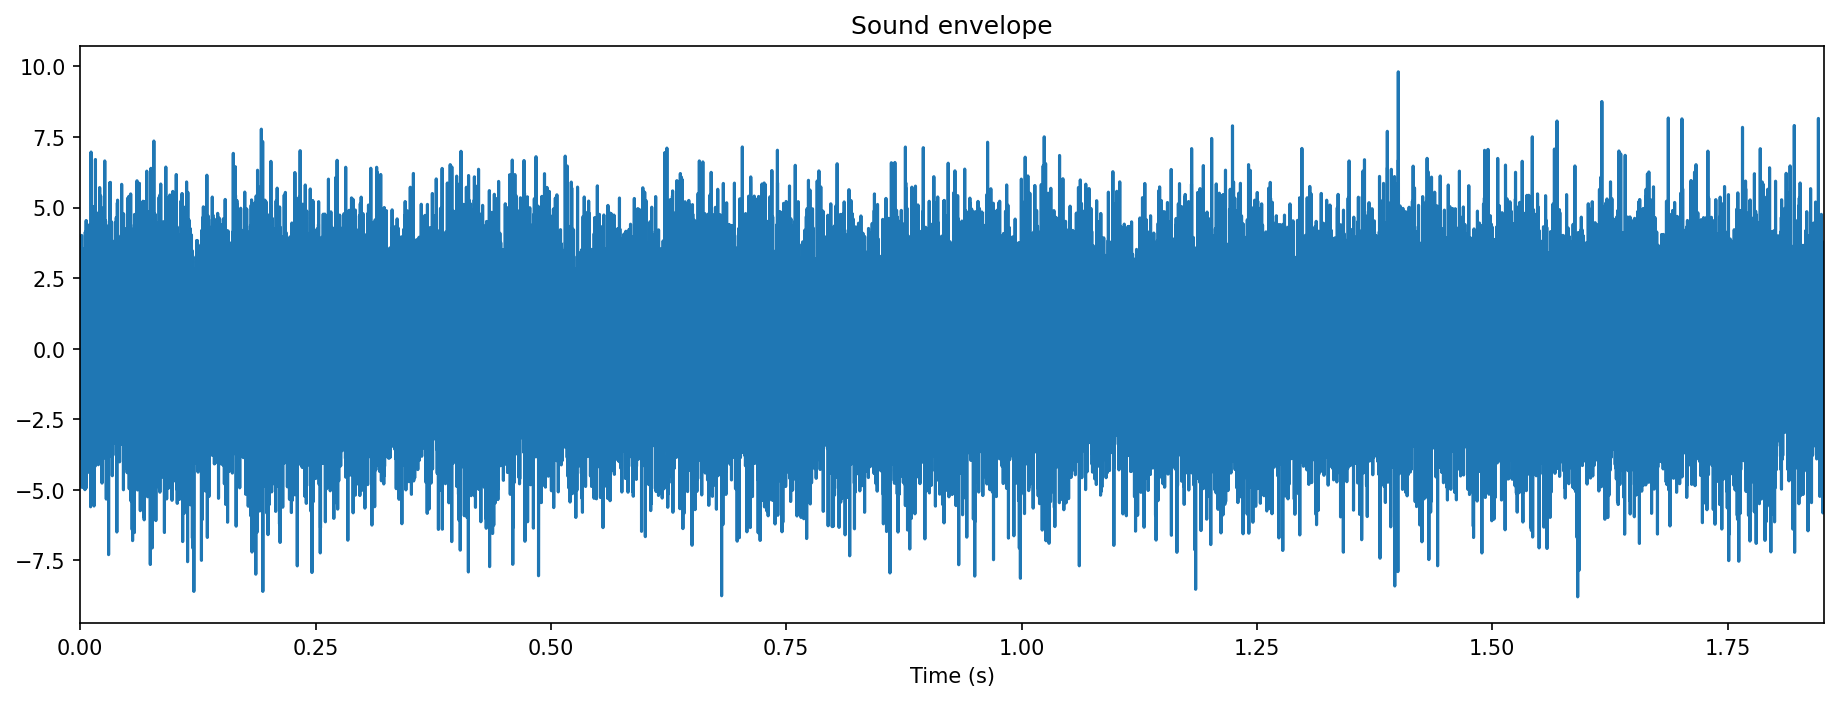

In [6]:
plot_envelope(signal, title = "Sound envelope")

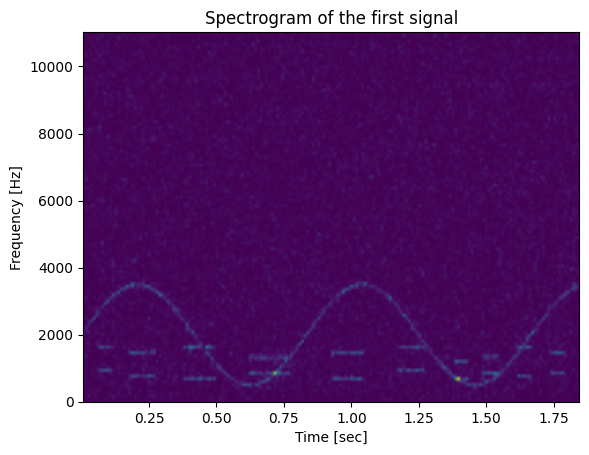

In [7]:
plot_spectrogram(*my_spectro(signal), title = "Spectrogram of the first signal")

<Figure size 640x480 with 0 Axes>

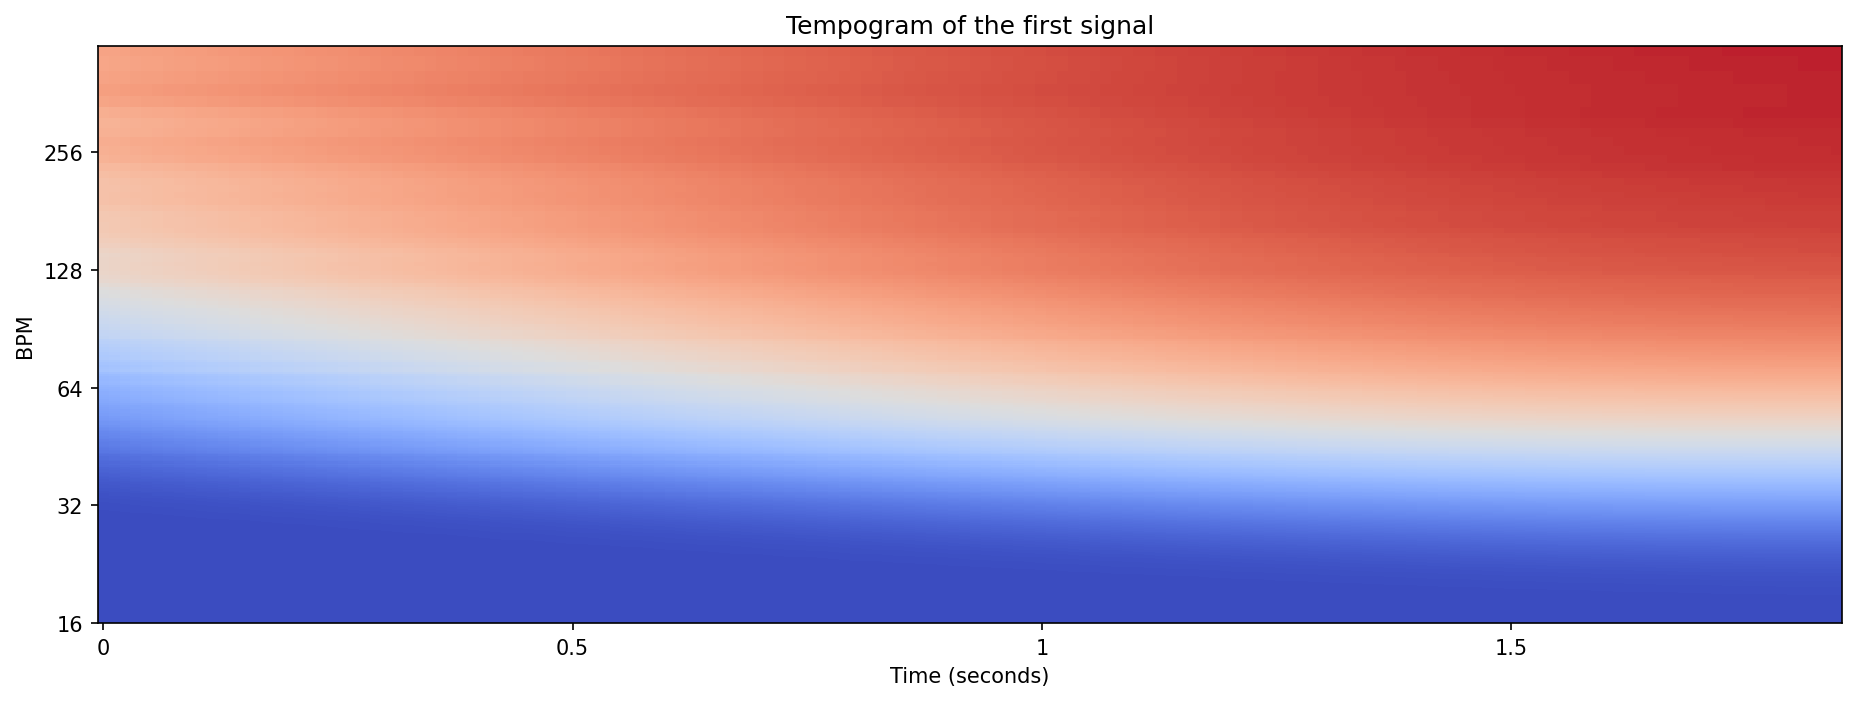

In [8]:
plot_tempogram(my_tempo(signal), title = "Tempogram of the first signal")

<Figure size 640x480 with 0 Axes>

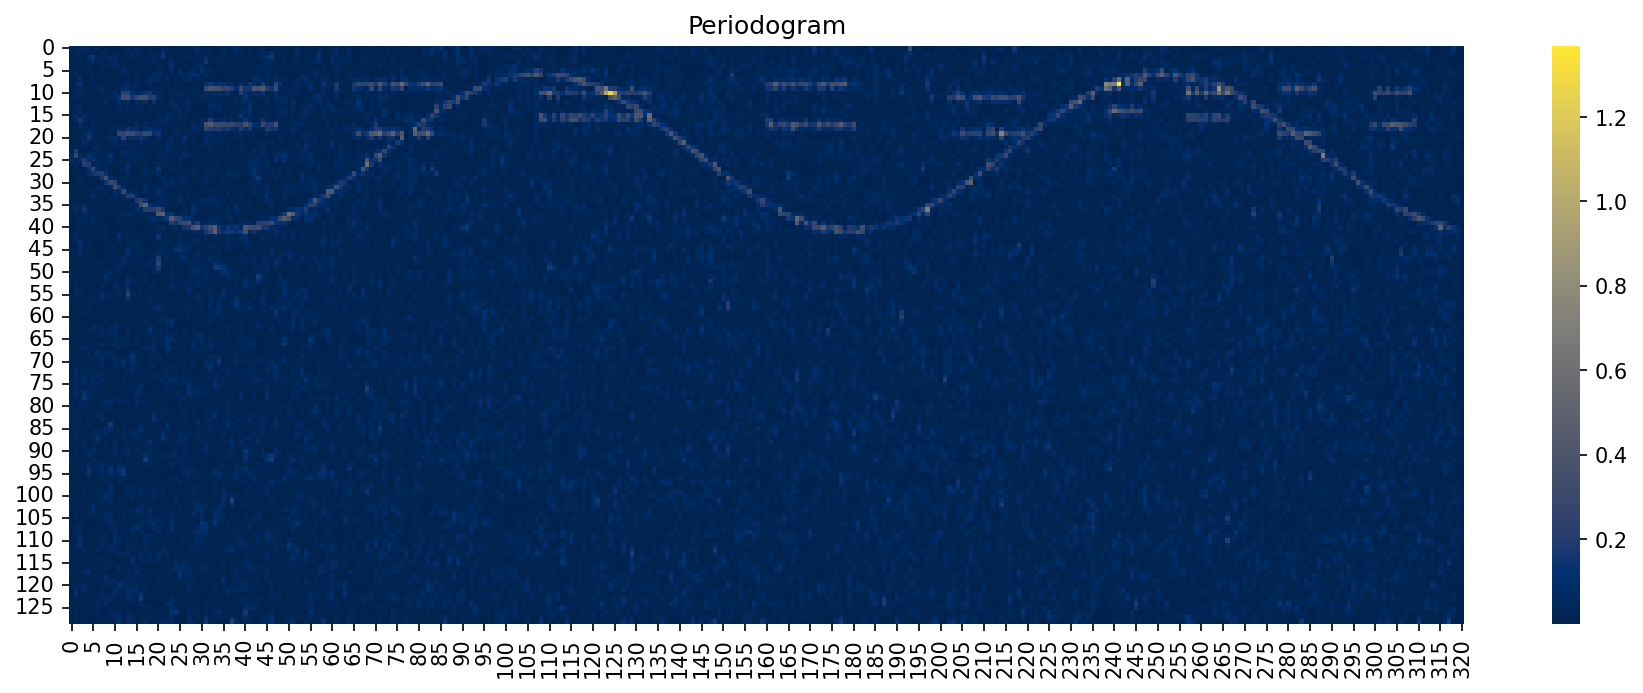

In [311]:
plot_2d(my_perio(signal))

The periodogram present all the features we need for the classification, and is fast to compute.

### Breakpoints detections selection

In [10]:
perio =  my_perio(signal)

In [11]:
algo = rpt.Dynp(model='l2', jump=1).fit( perio.T)
predicted_bkps = algo.predict(n_bkps=len(symbols)*2)

In [12]:
algo2 = rpt.KernelCPD(kernel="linear").fit(perio.T)
predicted_bkps2 = algo2.predict(n_bkps=len(symbols)*2)

In [13]:
print(predicted_bkps)
print(predicted_bkps2)

[31, 48, 66, 86, 108, 123, 126, 134, 160, 181, 203, 220, 238, 242, 257, 268, 278, 287, 300, 309, 321]
[31, 48, 66, 86, 108, 123, 126, 134, 160, 181, 203, 220, 238, 242, 257, 268, 278, 287, 300, 309, 321]


<Figure size 640x480 with 0 Axes>

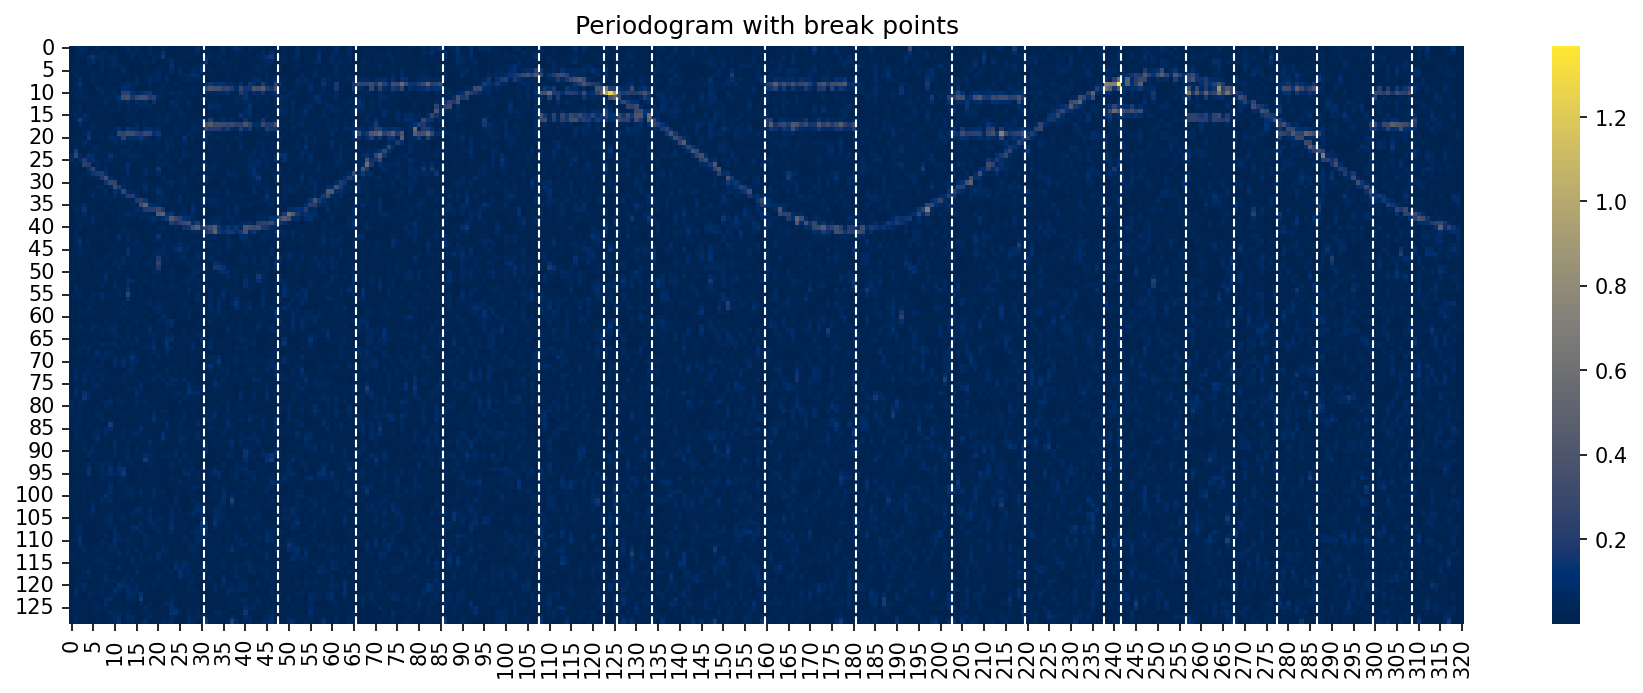

In [312]:
plot_2d(perio, "Periodogram with break points",predicted_bkps2)

The linear model is too sensitive not to be disturbed by the continuous signal we're trying to ignore. The kernel cosine performs a normalization that prevents the detection of a break when the two signals are constructively interacting.

<Figure size 640x480 with 0 Axes>

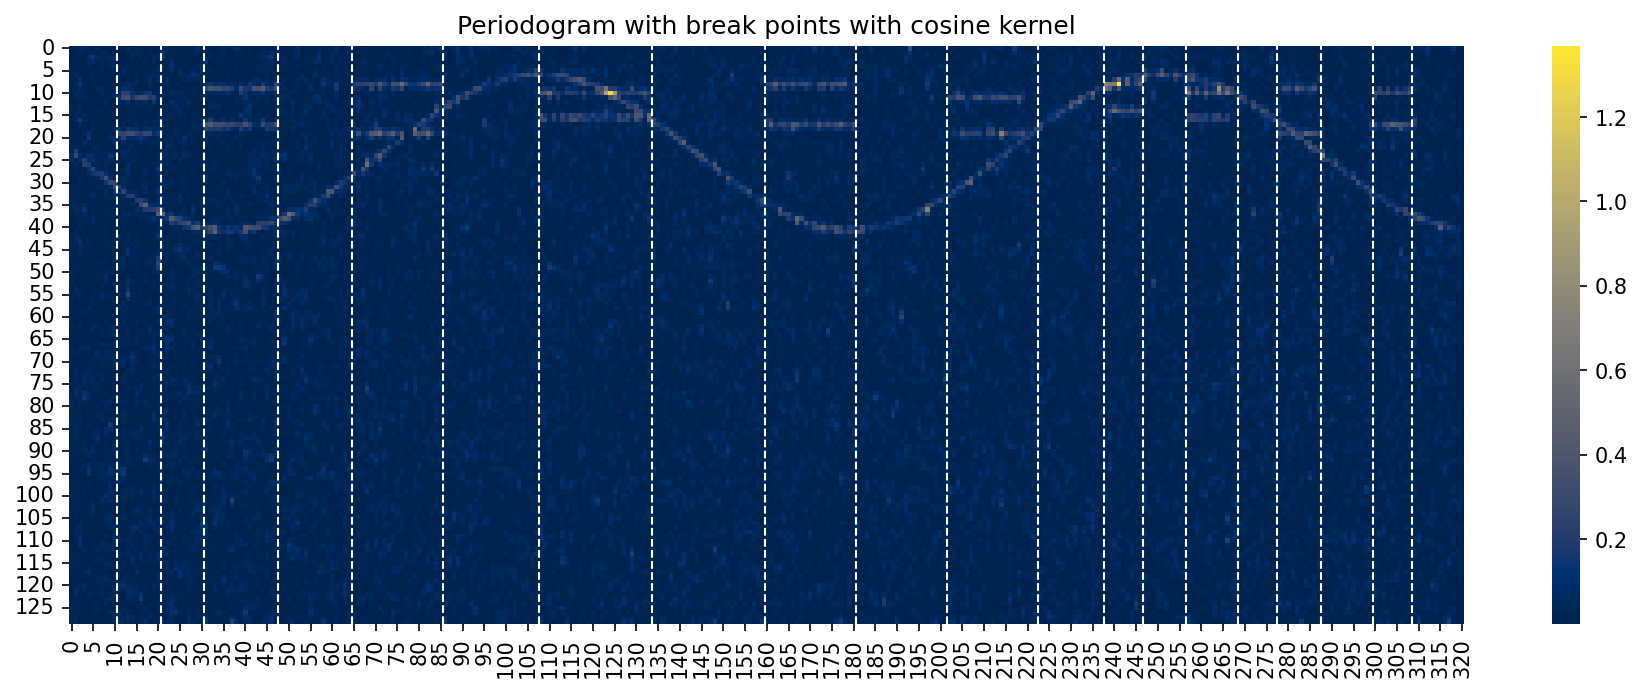

In [313]:
algo3 = rpt.KernelCPD(kernel="cosine").fit( perio.T)
predicted_bkps3 = algo3.predict(n_bkps=len(symbols)*2)
plot_2d(perio, "Periodogram with break points with cosine kernel",predicted_bkps3)

Now let's find the right number of breaks and automatically.

### number of breakpoints selection

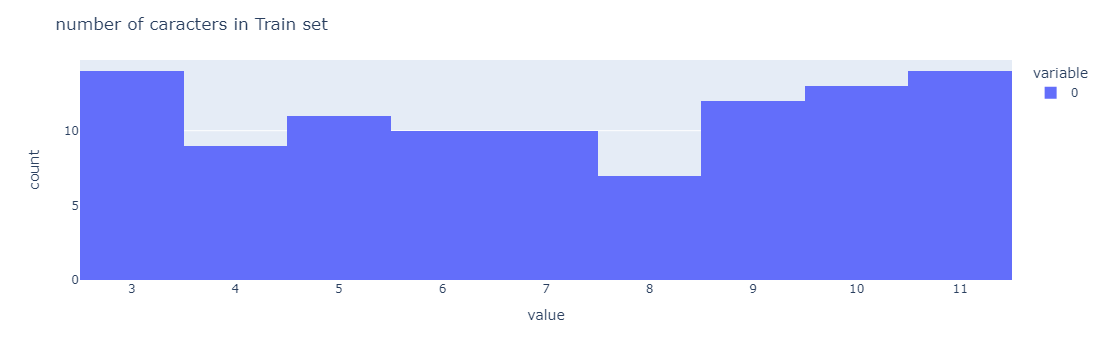

In [16]:
px.histogram(list(map(len, y_train)) ).update_layout(title = "number of caracters in Train set")

In [314]:
predicted_bkps4 = rpt.Pelt(model="cosine",min_size = 5, jump=1).fit_predict(signal=perio.T, pen=0.8)

The penalization is one of the parameters to tune.

<Figure size 640x480 with 0 Axes>

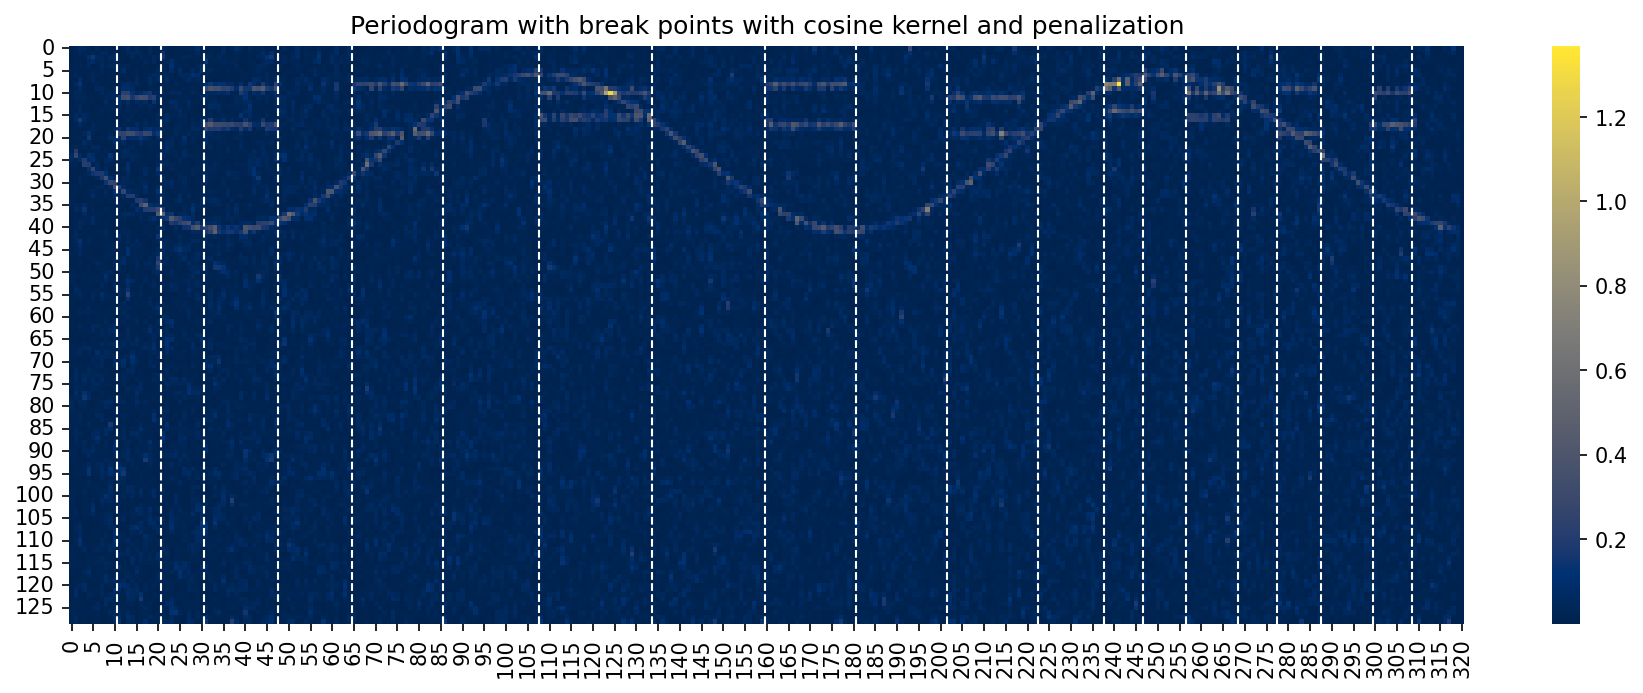

In [291]:
plot_2d(perio, "Periodogram with break points with cosine kernel and penalization",predicted_bkps4)

### Segments processing

In [486]:
# def get_symb_segment(perio, bkps, max_k = None):
#     max_i = len(bkps)-1
#     lst_seg = []
#     lst_stat = []
        
#     for i in range(max_i+1):
#         if i==0 and 0 not in bkps:
#             seg = perio[:, :bkps[i]]
            
#         elif i==max_i and bkps[-1]!= perio.shape[1]:
#             seg = perio[:, bkps[-1]:]
#         else:
#             seg = perio[:, bkps[i-1]-1:bkps[i]]
            
#         if max_k:
#             lst_stat.append(np.mean(seg[:max_k,:])) 
#             lst_seg.append(seg[:max_k,:])
#         else:
#             lst_stat.append(np.mean(seg)) 
#             lst_seg.append(seg)
#     # elimination of silences
#     stats = np.array(lst_stat)
#     standard_stats =  (stats - stats.min()) / (stats.max() - stats.min())
#     lst_seg_symbol = []
#     lst_pair = []
#     lst_impairs = []

#     for i,seg in enumerate(lst_seg):
#         if standard_stats[i]>=0.55:
#             lst_seg_symbol.append(seg)
#     return lst_seg_symbol

def get_symb_segment(perio, bkps, max_k = None):
    max_i = len(bkps)-1
    lst_seg = []
    lst_stat = []
    pair_sum_energy = 0
    impaire_sum_energy = 0
    
    for i in range(max_i+1):
        if i==0 and 0 not in bkps:
            seg = perio[:, :bkps[i]]
            
        elif i==max_i and bkps[-1]!= perio.shape[1]:
            seg = perio[:, bkps[-1]:]
        else:
            seg = perio[:, bkps[i-1]-1:bkps[i]]

        if max_k:
            lst_seg.append(seg[:max_k,:])
        else:
            lst_seg.append(seg)
        if i%2==0:
            pair_sum_energy += np.mean(lst_seg[-1])
        else:
            impaire_sum_energy += np.mean(lst_seg[-1])
            
    # elimination of silences
    if pair_sum_energy>impaire_sum_energy:
        lst_seg_symbol = lst_seg[::2].copy()
    else:
        lst_seg_symbol = lst_seg[1::2].copy()

    return lst_seg_symbol

def get_temporal_sum_by_seg(lst_seg):
    seg_sum = np.zeros((len(lst_seg), lst_seg[0].shape[0]))
    for i,seg in enumerate(lst_seg):
        seg_sum[i,:] = np.sum(seg, axis = 1)
    return seg_sum

    
# def denoise_segments(lst_seg, wavelet = "haar", thrs =  0.1):
#     lst_denoised = []
#     for seg in lst_seg:
#         coeffs = pywt.wavedec2(np.array(seg), wavelet, 
#                                    axes=(0, 1)
#                               )
#         for l in range(1,len(coeffs)):
#             coeffs[l] = list(coeffs[l ]) # convert tuple (immutable) to list (mutable)
#             for i in range(3):
#                 coeffs[l ][i] = pywt.threshold(np.array(coeffs[l][i]), thrs, mode='soft')
    
#         lst_denoised.append( pywt.waverec2(coeffs, wavelet, axes=(0, 1)))
#     return lst_denoised



<Figure size 640x480 with 0 Axes>

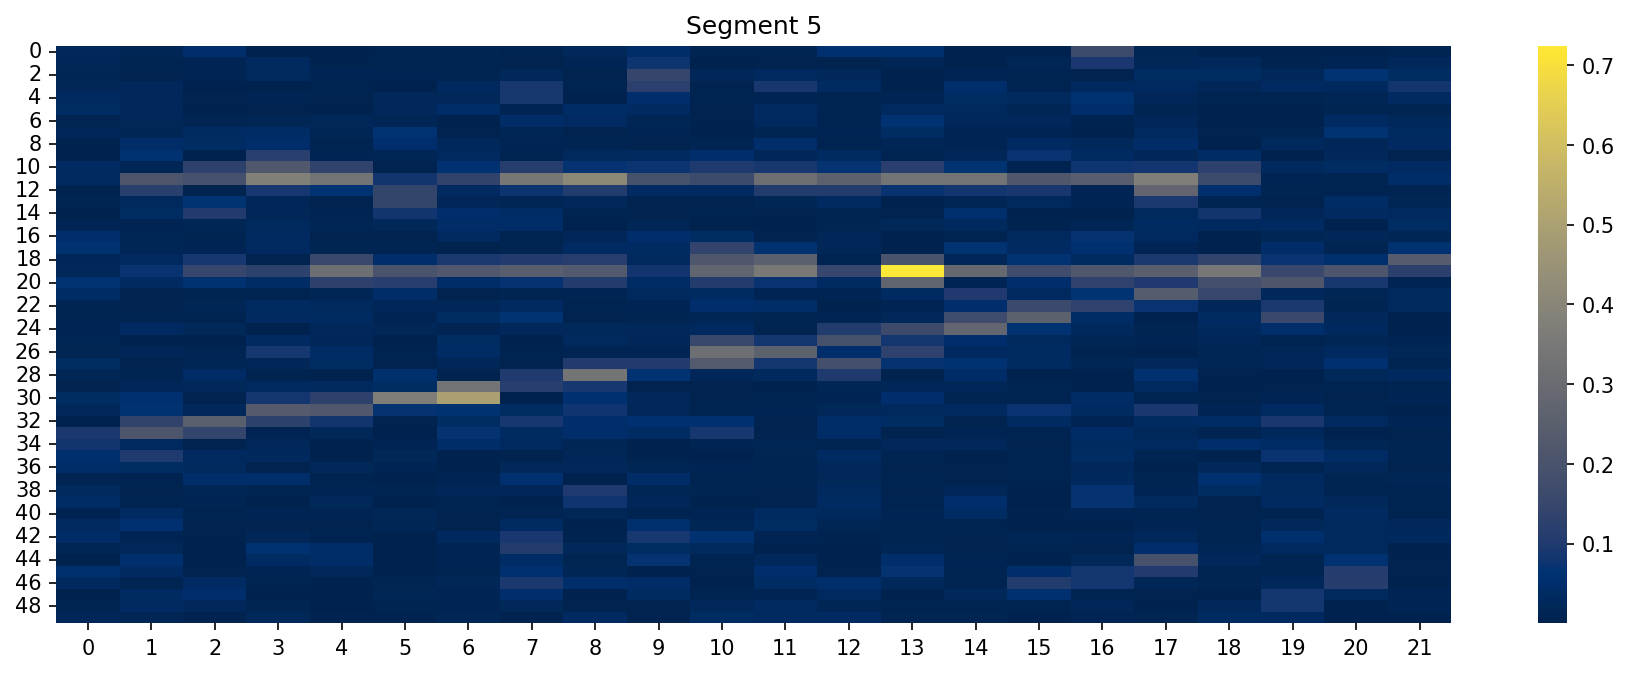

In [484]:
lst_seg = get_symb_segment(perio, predicted_bkps4, max_k=50)
plot_2d(lst_seg[5], f"Segment 5")

To recover the 2 frequencies of the signals we take advantage of the constancy of these signals which consequently present high temporal sums

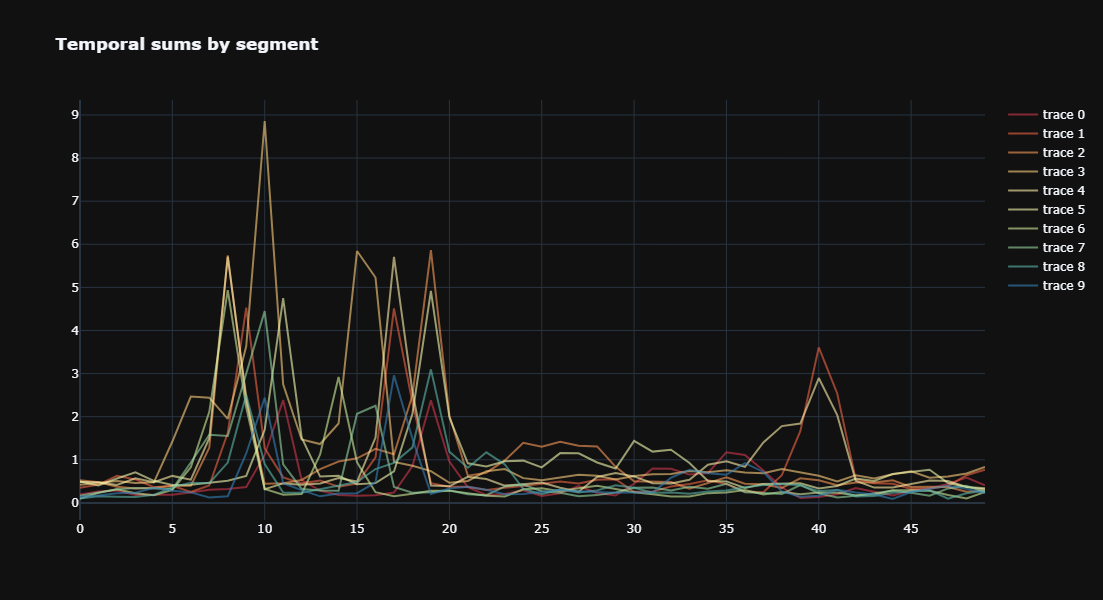

In [485]:
plot_all_st(get_temporal_sum_by_seg(lst_seg),  title="<b>Temporal sums by segment</b>")

In [335]:
def largest_indices(ary, n):
    """Returns the n largest indices from a numpy array."""
    flat = ary.flatten()
    indices = np.argpartition(flat, -n)[-n:]
    indices = indices[np.argsort(-flat[indices])]
    return np.unravel_index(indices, ary.shape)[0]

largest_indices(get_temporal_sum_by_seg(lst_seg)[0,:], 2)

array([11, 19], dtype=int64)

### Signal to dual-tone

In [583]:
def extract_dual_tones(signal, max_k = 50, beta = 0.8):
    perio =  my_perio(signal)
    predicted_bkps = rpt.Pelt(model="cosine",min_size = 5, jump=1).fit_predict(signal=perio.T, pen=beta)
    lst_seg = get_symb_segment(perio, predicted_bkps, max_k=max_k)
    sums_by_seg = get_temporal_sum_by_seg(lst_seg)
    dualtone_idx = np.zeros((sums_by_seg.shape[0],2))
    for i in range(sums_by_seg.shape[0]):
        dualtone_idx[i,:] = np.sort(largest_indices(sums_by_seg[i,:], 2))
    return dualtone_idx

In [584]:
extract_dual_tones(signal, max_k = 50, beta = 0.8)

array([[11., 19.],
       [ 9., 17.],
       [ 8., 19.],
       [10., 15.],
       [ 8., 17.],
       [11., 19.],
       [ 8., 14.],
       [ 9., 10.],
       [ 9., 19.],
       [10., 17.]])

In [585]:
def extract_all_dual_tones(xtrain, max_k = 50, beta = 0.8):
    lst_mat = [extract_dual_tones(sign, max_k = max_k, beta = beta) for sign in xtrain]
    return np.concatenate(lst_mat)

### dual tone classification

In [465]:
import itertools
def prepare_train_test(X_train, y_train, max_k = 50, beta = 0.8):
    x_train, x_test, y2_train, y2_test = train_test_split( X_train, y_train, test_size=0.33, random_state=42)
    x_train = extract_all_dual_tones(x_train, max_k, beta)
    x_test = extract_all_dual_tones(x_test, max_k, beta)
    y2_train = np.array(list(itertools.chain(*y2_train)))
    y2_test = np.array(list(itertools.chain(*y2_test)))
    return x_train, x_test, y2_train, y2_test

We now adjust the parameters in order to detect the right number of segments

In [615]:
x_train, x_valid, y2_train, y2_valid = prepare_train_test(X_train, y_train, max_k = 70, beta = 1.08)

In [616]:
print(x_train.shape, y2_train.shape)
print(x_test.shape, y2_test.shape)

(476, 2) (469,)
(233, 2) (242,)


In [596]:
def extract_dual_tones_knowing_symb(signal, symboles, max_k = 50, beta = 0.8):
    perio =  my_perio(signal)
    predicted_bkps = rpt.KernelCPD(kernel="cosine").fit_predict(perio.T, n_bkps=len(symboles)*2-1)

    lst_seg = get_symb_segment(perio, predicted_bkps, max_k=max_k)
    sums_by_seg = get_temporal_sum_by_seg(lst_seg)
    # print(len(predicted_bkps), sums_by_seg.shape[0], len(symboles))
    dualtone_idx = np.zeros((sums_by_seg.shape[0],2))
    for i in range(sums_by_seg.shape[0]):
        dualtone_idx[i,:] = largest_indices(sums_by_seg[i,:], 2)
    return dualtone_idx

In [587]:
def extract_all_dual_tones_knowing_symb(xtrain, ytrain, max_k = 50, beta = 0.8):
    lst_mat = [extract_dual_tones_knowing_symb(sign, ytrain[i], max_k = max_k, beta = beta) for i,sign in enumerate(xtrain)]
    return np.concatenate(lst_mat)

In [575]:
def prepare_train_test_right_format(X_train, y_train, max_k = 60, beta = 0.54):
    x_train, x_test, y2_train, y2_test = train_test_split( X_train, y_train, test_size=0.20, random_state=18)
    x_train = extract_all_dual_tones_knowing_symb(x_train, y2_train, max_k, beta)
    x_test = extract_all_dual_tones_knowing_symb(x_test, y2_test, max_k, beta)
    y2_train = np.array(list(itertools.chain(*y2_train)))
    y2_test = np.array(list(itertools.chain(*y2_test)))
    return x_train, x_test, y2_train, y2_test

In [621]:
x_train, x_valid, y2_train, y2_valid = prepare_train_test_right_format(X_train, y_train, max_k = 70)

In [622]:
print(x_train.shape, y2_train.shape)
print(x_valid.shape, y2_valid.shape)

(555, 2) (555,)
(156, 2) (156,)


In [623]:
cls = GradientBoostingClassifier(n_estimators=300)
cls.fit(x_train, y2_train)
train_score = cls.score(x_train, y2_train)
test_score = cls.score(x_valid, y2_valid)
print(f"Train Score : {np.round(train_score,2)}")
print(f"Valid Score : {np.round(test_score,2)}")

Train Score : 0.75
Valid Score : 0.58


# Question 2

In [629]:
X_test = np.load("X_test.npy", allow_pickle=True).tolist()
my_display(X_test[0])
my_display(X_test[1])

In [661]:
x_test1 = extract_dual_tones(X_test[0], max_k = 70, beta = 1.3)
x_test2 = extract_dual_tones(X_test[1], max_k = 70, beta = 1.4)

In [662]:
pred1 =  " ".join(cls.predict(x_test1))
pred2 = " ".join(cls.predict(x_test2))
print(pred1,"\n", pred2)

7 2 1 9 9 
 1 # 2 #


# Question 3

# Question 4

# Question 5

# Question 6

# Question 7